## Measure the covariance using peak height
* Sort the clusters by (nu) and see if that washes the differences away between (M,z) bins in terms of covariance shape. 

## Import

In [1]:
## Use the setup.py file to output directories. 
import sys
sys.path.append('/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/')

from setup import *
toolsdir = tools_dir()
repodir = repo_dir()
chainsdir = chains_dir()
datadir = data_dir()
plotdir = plots_dir()

sys.path.append(toolsdir)
sys.path.append(repodir)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import scipy.stats as stats
import matplotlib.cm as cm
#from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_selection import f_regression
from statsmodels.stats.anova import anova_lm
from statsmodels.compat import lzip
#sns.set()
#pd.set_option('display.notebook_repr_html', True)
#pd.set_option('display.precision', 2)
#%matplotlib notebook
#plt.rcParams['figure.figsize'] = 10, 10
from scipy.stats import norm
from scipy import stats

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
## KLLR setup
import sys
sys.path.append('/global/u1/z/zzhang13')

from kllr.kllr.regression_model import *
from kllr.kllr.regression_plotting import *
from kllr.kllr.calc_cov_KLLR import *

kllr_nbins= 20
kernel_type = 'gaussian'
kernel_width = 0.1

In [5]:
from data_bins import r_cent_lin_norm, r_cent_log_norm
from data_bins import mass_bins, mass_bin_cent
from data_bins import a_bins

## Halo Catalog

In [6]:
with open(datadir + 'MDPL2_DS_R200c_SAGE_Ngal_allM_allz.p', 'rb') as f:
    matched_halo_df = pickle.load(f)

In [7]:
matched_halo_df.columns

Index(['id', 'Xoff', 'scale', 'CtreesHaloID', 'pid', 'mvir', 'rvir', 'rs', 'x',
       'y', 'z', 'Mmvir_all', 'M200b', 'M200c', 'M500c', 'T/|U|',
       'Halfmass_Scale', 'Acc_Rate_Inst', 'Acc_Rate_100Myr', 'Acc_Rate_1*Tdyn',
       'Acc_Rate_2*Tdyn', 'Acc_Rate_Mpeak', 'c_vir', 'R200c', 'R500c',
       'redshift', 'Ngal_Dsep_1', 'Ngal_Rvir', 'Ngal_R200c', 'Ngal_R500c',
       'sigma', 'r_range', 'delta_sigma'],
      dtype='object')

## Rebinning by peak height
* Explain why the peak height measured by the function and one measured by individually measuring delta_c and sigma(R) don't match.

In [8]:
from colossus.cosmology import cosmology
from colossus.lss import peaks

cosmo = cosmology.setCosmology('planck18')

Deleted outdated persistence file, no further action needed.


In [9]:
nu = peaks.peakHeight(matched_halo_df.M200c, 1/matched_halo_df.scale - 1 )
delta_c = 1.686 ##Assume this doesn't change
sigma_R = nu/delta_c

In [10]:
matched_halo_df['nu'] = nu
matched_halo_df['sigma_R'] = sigma_R

## Bin in quintiles of nu

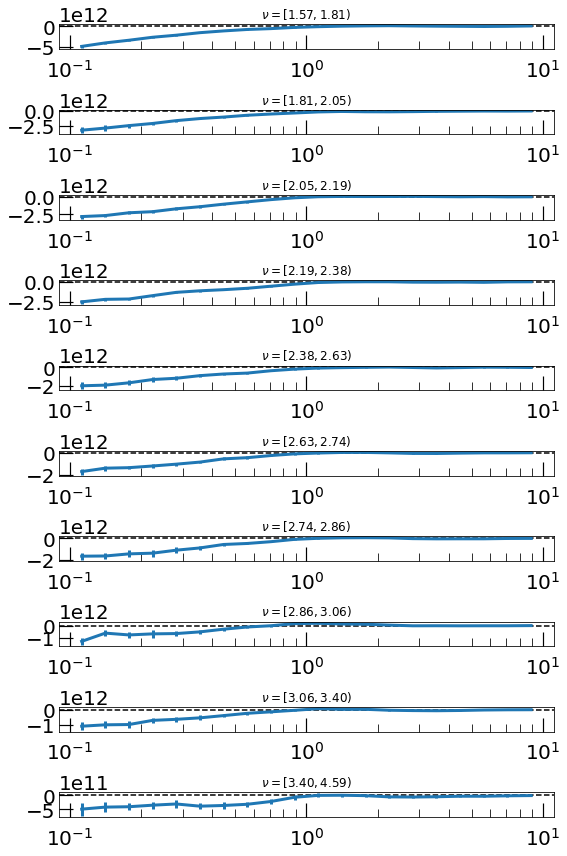

In [11]:
from scipy import stats

split_samp_bins_edge = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
x_var_bin = [[] for i in range(len(split_samp_bins_edge)-1)]
bin_num = len(x_var_bin)
nBootstrap=10

fig, axs = plt.subplots(bin_num,figsize=(8,12))
   
for k in range(bin_num):
    bin_low = split_samp_bins_edge[k]
    bin_high = split_samp_bins_edge[k+1]

    x_var = matched_halo_df['nu']
    percentile_x_var = np.vectorize(lambda x: stats.percentileofscore(x_var, x))(x_var)
    mask = (percentile_x_var >= bin_low) & (percentile_x_var < bin_high)
    
    x_var_bin[k] = x_var[mask]
    cur_df = matched_halo_df[mask] ##This needs to change

    ##Compute Cov. and error total
    xline, output = calc_cov_KLLR(np.log10(np.array(cur_df['M200c'],dtype=float)) , np.array(np.vstack(cur_df['delta_sigma']), dtype=float), \
                                       np.log10(np.array(cur_df['Ngal_R200c'],dtype=float)), nBootstrap=nBootstrap)
    cov_ds_ngal_kllr = output['covariance']
    cov_mean_kllr = np.mean(cov_ds_ngal_kllr, axis=0)
    cov_err_kllr = np.std(cov_ds_ngal_kllr, axis=0)
    axs[k].errorbar(r_cent_lin_norm, cov_mean_kllr, yerr=cov_err_kllr, label='Total', linestyle='solid', linewidth=3)
        
    ##Plotting configu
    axs[k].axhline(0,linestyle='dashed', color='black')
    axs[k].set_xscale('log'); #plt.yscale('log')
    axs[k].set_title(r'$\nu = [{:.2f}, {:.2f})$'.format(np.min(cur_df.nu), np.max(cur_df.nu)), fontsize=12)
        

fig.tight_layout()
plt.show()

## Parameterize by peak height
* Samples by every 10th percentile in $\nu$ the peak height parameter. 
* Attempts with the full model and the reduced model

In [12]:
from mcmc_reduced_model import *

In [13]:
## MCMC config
Nwalkers = 50
Nsample = int(2e4)
burn_in = 500
thin = 100 
maxlag=1000
#x0 = [0.5,-0.5,-1,1e11]

In [14]:
model_dict ={
             'erf_reduced':{'Ndim':3, 'model_func':model_erf_reduced, 'x0':[0.5, -0.5, 1e12], 'x_final:':[],
                         }
            }

### Creates a mean_nu variable

1.5712260419009514 1.805913273132302
1.8066909376891718 2.0462089522963547
2.046486308787405 2.187044127851371
2.187294492635483 2.384425990310055
2.3845278928372116 2.6317677397911057
2.631852660367608 2.7412153578408605
2.741479416152899 2.8623101801939232
2.862530954060255 3.0630402852597514
3.0634163713141547 3.3987074207350645


(array([ 688.,  884.,  733., 1147.,  755.,  332.,  295.,   80.,   14.,
           2.]),
 array([1.57122604, 1.8941497 , 2.21707335, 2.53999701, 2.86292066,
        3.18584432, 3.50876797, 3.83169163, 4.15461528, 4.47753894,
        4.80046259]),
 <BarContainer object of 10 artists>)

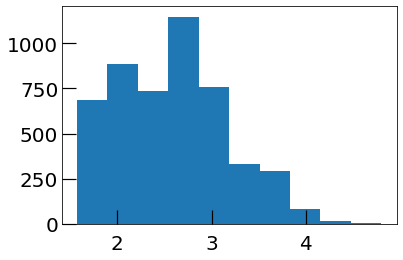

In [15]:
split_samp_bins_edge = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
x_var_bin = [[] for i in range(len(split_samp_bins_edge)-1)]
bin_num = len(x_var_bin)
mean_nu = np.zeros(bin_num)
   
for k in range(bin_num):  
        bin_low = split_samp_bins_edge[k]
        bin_high = split_samp_bins_edge[k+1]

        x_var = matched_halo_df['nu']
        percentile_x_var = np.vectorize(lambda x: stats.percentileofscore(x_var, x))(x_var)
        mask = (percentile_x_var >= bin_low) & (percentile_x_var < bin_high)

        x_var_bin[k] = x_var[mask]
        cur_df = matched_halo_df[mask] ##This needs to change
        mean_nu[k] = np.mean(cur_df.nu)
        print(np.min(cur_df.nu), np.max(cur_df.nu))
        
plt.hist(matched_halo_df['nu'])


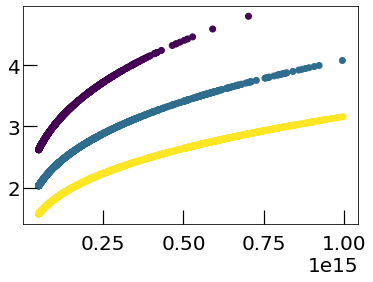

In [16]:
colors = {'North America':'red', 'Europe':'green', 'Asia':'blue', 'Australia':'yellow'}
plt.scatter(matched_halo_df['M200c'], matched_halo_df['nu'], c=matched_halo_df['scale'])

### Samples an individual bin

### Iterate over all bins

erf_reduced
Optimization terminated successfully.
         Current function value: 539.736859
         Iterations: 158
         Function evaluations: 377


 28%|██▊       | 5698/20000 [00:31<01:19, 179.26it/s]Traceback (most recent call last):
  File "/global/homes/z/zzhang13/.conda/envs/myLSST/lib/python3.7/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/tools/mcmc_reduced_model.py", line 100, in lnprob
    return lp + lnlike(p, model, x, y, err)
  File "/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/tools/mcmc_reduced_model.py", line 74, in lnlike
    fit = model(p,x)
  File "/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/tools/mcmc_reduced_model.py", line 111, in model_erf_reduced
    x_tilde = (x-gamma)/tau
KeyboardInterrupt
 29%|██▊       | 5702/20000 [00:31<01:19, 180.73it/s]


emcee: Exception while calling your likelihood function:
  params: [ 4.66834189e-01 -6.93278679e-01  3.05090004e+12]
  args: (<function model_erf_reduced at 0x1554feab4830>, array([-0.95, -0.85, -0.75, -0.65, -0.55, -0.45, -0.35, -0.25, -0.15,
       -0.05,  0.05,  0.15,  0.25,  0.35,  0.45,  0.55,  0.65,  0.75,
        0.85,  0.95]), array([-4.78674943e+12, -4.02812182e+12, -3.39072935e+12, -2.61485382e+12,
       -2.16038142e+12, -1.55461108e+12, -1.13004028e+12, -7.55220603e+11,
       -5.37866757e+11, -2.70756634e+11, -1.16135183e+11,  1.49949141e+10,
        8.25192363e+10,  1.29870551e+11,  6.76732858e+10,  3.30003183e+10,
        5.23556751e+09, -4.68077873e+10,  2.25913539e+09,  7.61219837e+10]), array([5.64558230e+11, 4.29212454e+11, 3.70481846e+11, 2.58316336e+11,
       2.08712336e+11, 1.57587662e+11, 1.36155336e+11, 1.01891170e+11,
       7.39087858e+10, 4.32532110e+10, 4.27468880e+10, 4.70233653e+10,
       4.01929761e+10, 4.26341253e+10, 4.52691984e+10, 5.02143838e+10,
  

KeyboardInterrupt: 

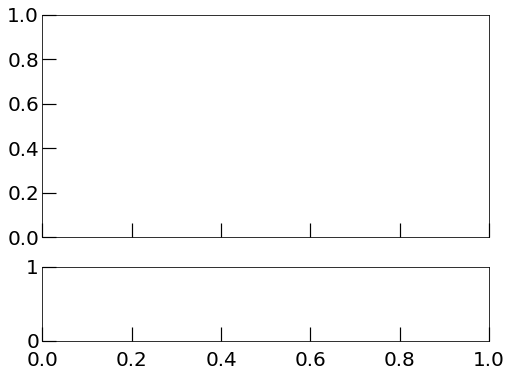

In [17]:
from scipy import stats
import scipy.optimize as opt
import emcee
import tqdm

nBootstrap = 20

split_samp_bins_edge = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
#split_samp_bins_edge = [90,100]
x_var_bin = [[] for i in range(len(split_samp_bins_edge)-1)]
bin_num = len(x_var_bin)
   
for k in range(bin_num):  
        bin_low = split_samp_bins_edge[k]
        bin_high = split_samp_bins_edge[k+1]

        x_var = matched_halo_df['nu']
        percentile_x_var = np.vectorize(lambda x: stats.percentileofscore(x_var, x))(x_var)
        mask = (percentile_x_var >= bin_low) & (percentile_x_var < bin_high)

        x_var_bin[k] = x_var[mask]
        cur_df = matched_halo_df[mask] ##This needs to change

        if len(cur_df) < 100: 
            #axs[i,j].set_visible(False)
            continue
        
        ##Compute Cov. and error total
        xline, output = calc_cov_KLLR(np.log10(np.array(cur_df['M200c'],dtype=float)) , np.array(np.vstack(cur_df['delta_sigma']), dtype=float), \
                                           np.log10(np.array(cur_df['Ngal_R200c'],dtype=float)), nBootstrap=nBootstrap)

        cov_ds_ngal_kllr = output['covariance']
        cov_mean_kllr = np.mean(cov_ds_ngal_kllr, axis=0)
        cov_err_kllr = np.std(cov_ds_ngal_kllr, axis=0)

        ##Data vector for chains
        x_data = r_cent_log_norm; y_data = cov_mean_kllr; y_err = cov_err_kllr

        f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(8,6), sharex=True)
        k=0
        for key, value in model_dict.items():
                print(key)
                if key != 'erf_reduced': continue 
                Ndim = value['Ndim']
                model = value['model_func']
                x0 = value['x0']


                filename = chainsdir+"R200c_binned/Dsep_R200c/reduced_erf_nu_{:.2f}_{:.2f}.h5py".format(np.min(cur_df.nu), np.max(cur_df.nu))

                best_fit_params, flatchain = run_model_chains(Nwalkers, Ndim, Nsample, model, x_data, y_data, y_err, x0, \
                                 burn_in=burn_in, thin=thin, maxlag=maxlag, savefile=True, filename=filename, verbose=True)

                model_dict[key]['x_final'] = best_fit_params
                fit = model(best_fit_params[:,0], x_data)


                a0.plot(x_data, fit, label=key, color='C{}'.format(k), linewidth=3)
                a1.errorbar(x_data, y_data-fit, yerr=y_err, marker="o", capsize=3, linestyle='None',color='C{}'.format(k), label=key)
                k+=1

        a0.axhline(0, linestyle='--', color='black')
        a0.errorbar(x_data, y_data, yerr=y_err, label='Cov', marker="o", capsize=3, linestyle='None', color='C5')  
        a0.legend(loc='lower right', fontsize=14)
        a0.set_ylabel(r'$\rm{Cov}(\Delta\Sigma, N_{\rm gal})$', fontsize=20)

        a1.axhline(0, linestyle='--', color='black')
        a1.set_ylabel(r'$\Delta \rm{Cov}(\Delta\Sigma, N_{\rm gal})$', fontsize=14)
        a1.set_xlabel(r'$\log_{10}(R/R_{\rm vir})$', fontsize=20)

        plt.suptitle(r'$\nu = [{:.2f}, {:.2f})$'.format(np.min(cur_df.nu), np.max(cur_df.nu)), fontsize=12)

        
        f.tight_layout()
            #f.savefig(plot_dir+'cov_all_models_data_vs_fit_M{:.2g}_{:.2g}_z{}.pdf'.format(mass_min, mass_max, redshift_str))
        plt.show()

## Modeling the peak height dependence

In [20]:
from mcmc_full_models import *

In [21]:
from glob import glob
fontsize=20
legendsize=14
Ndim=4
split_samp_bins_edge = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
x_var_bin = [[] for i in range(len(split_samp_bins_edge)-1)]
bin_num = len(x_var_bin)
y = np.zeros(bin_num)
yerr = np.zeros((bin_num,2)).T

best_tau = np.zeros((bin_num,3))
best_gamma = np.zeros((bin_num,3))
best_h = np.zeros((bin_num,3))
best_s = np.zeros((bin_num,3))

x_data = r_cent_log_norm; y_data = np.zeros_like(r_cent_log_norm); y_err = np.ones_like(r_cent_log_norm)

from glob import glob
files = sorted(glob(chainsdir + 'R200c_binned/Dsep_R200c/' + 'chains_nu_*'))
for k, file in enumerate(files):
        #print(file,k)
        if k >= bin_num: break
        try:
            f = h5py.File(file,'r')
        except:
            continue
        
        chain = np.array(f['chains'])
        #flatchain = chain.reshape((-1,Ndim)).T
        best_fit_params, DIC_nominal, BIC_nominal, p_val = posterior_summary_stats(chain, model_erf, Ndim, x_data, y_data, y_err, verbose=False)
        
        
        best_tau[k] = best_fit_params[0,:]
        best_gamma[k] = best_fit_params[1,:]
        best_h[k] = best_fit_params[2,:]
        best_s[k] = best_fit_params[3,:]

## Plotting
* Make the average for tau, gamma, h
* Create the log-linear function for s with error-bars using the condifence bands. 

In [22]:
# Statistics
n = 9                                       # number of observations
m = 1                                                      # number of parameters
dof = n - m                                                # degrees of freedom
t = stats.t.ppf(0.84, n - m)                              # t-statistic; used for CI and PI bands
X_range = np.linspace(1.6,3.6,100)

## Confidence band for the log-linear relationship
expected_val = (-0.43856065*mean_nu + 13.0681573)
linear_fit = (-0.43856065*X_range + 13.0681573)
resid = -0.43856065*mean_nu + 13.0681573 - np.log10(best_s[:,0])                                      # residuals; diff. actual data from predicted values
chi2 = np.sum((resid / expected_val)**2)                      # chi-squared; estimates error in data
chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
s_err = np.sqrt(np.sum(resid**2) / dof)                    # standard deviation of the error
ci = t * s_err * np.sqrt(1/n + (X_range - np.mean(mean_nu))**2 / np.sum((mean_nu - np.mean(mean_nu))**2))

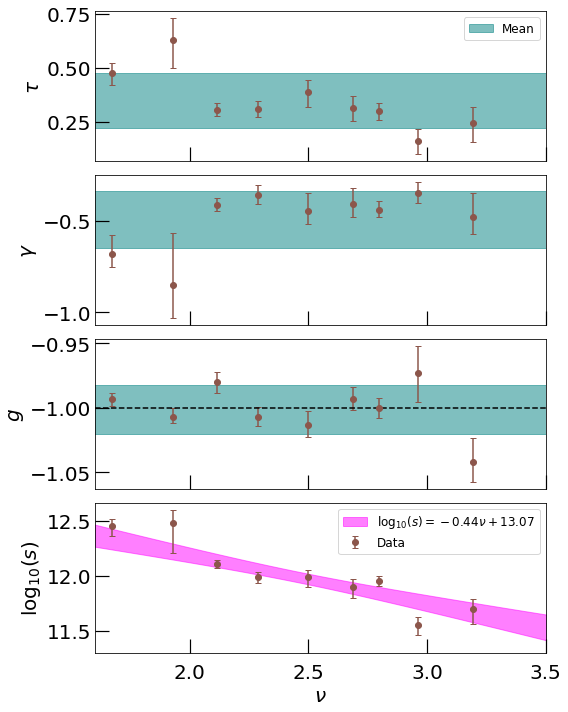

In [23]:
## Make this plot pretty.
fontsize=20
hband = np.linspace(0,10,len(mean_nu))
fig, axs = plt.subplots(4,1 , figsize=(8,10), sharex=True, tight_layout=True)
axs[0].errorbar(mean_nu, best_tau[:,0], yerr=[best_tau[:,1], best_tau[:,2]], marker="o", capsize=3, linestyle='None', color='C5')
axs[0].fill_between(hband, np.mean(best_tau[:,0])-np.std(best_tau[:,0]), np.mean(best_tau[:,0])+np.std(best_tau[:,0]), color='teal', alpha=0.5, label = 'Mean')

axs[1].errorbar(mean_nu, best_gamma[:,0], yerr=[best_gamma[:,1], best_gamma[:,2]], marker="o", capsize=3, linestyle='None', color='C5')
axs[1].fill_between(hband, np.mean(best_gamma[:,0])-np.std(best_gamma[:,0]), np.mean(best_gamma[:,0])+np.std(best_gamma[:,0]), color='teal', alpha=0.5)

axs[2].errorbar(mean_nu, best_h[:,0], yerr=[best_h[:,1], best_h[:,2]], marker="o", capsize=3, linestyle='None', color='C5')
axs[2].fill_between(hband, np.mean(best_h[:,0])-np.std(best_h[:,0]), np.mean(best_h[:,0])+np.std(best_h[:,0]), color='teal', alpha=0.5)
axs[2].axhline(-1, linestyle='dashed', color='black')

axs[3].errorbar(mean_nu, np.log10(best_s[:,0]), yerr=[best_s[:,1]/(np.log(10)*best_s[:,0]), best_s[:,2]/(np.log(10)*best_s[:,0])], \
                marker="o", capsize=3, linestyle='None', color='C5', label='Data')
axs[3].fill_between(X_range, linear_fit-ci, linear_fit+ci, color='magenta', alpha=0.5, label=r'$\log_{10}(s) = -0.44\nu + 13.07$')


#axs[3].fill_between(hband, np.mean(best_s[:,0])-np.std(best_s[:,0]), np.mean(best_s[:,0])+np.std(best_s[:,0]), color='orange', alpha=0.5)

axs[0].set_ylabel(r'$\tau$', fontsize=fontsize)
axs[1].set_ylabel(r'$\gamma$', fontsize=fontsize)
axs[2].set_ylabel(r'$g$', fontsize=fontsize)
axs[3].set_ylabel(r'$\log_{10}(s)$', fontsize=fontsize)
axs[3].set_xlabel(r'$\nu$', fontsize=fontsize)
axs[0].legend(fontsize=12)
axs[3].legend(fontsize=12)

#axs[3].set_yscale('log')
plt.xlim((1.6,3.5))
#plt.savefig(plotdir+'param_peakheight.pdf')

In [24]:
file = '/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/data/chains/R200c_binned/Dsep_R200c/chains_nu_2.84_3.05.h5py'
f = h5py.File(file,'r')
chain = np.array(f['chains'])
np.shape(chain)
chain = chain.reshape((-1,4))
chain[:,3] /= 1e12 #Reduce the s variable

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


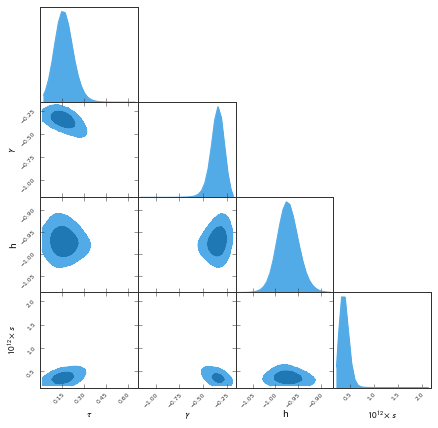

In [25]:
import pygtc

## Investigate what is going on with the second bin. Can you make a contour plot?
# List of parameter names, supports latex
# NOTE: For capital greek letters in latex mode, use \mathsf{}
names = [r'$\tau$', r'$\gamma$', 'h', r'$10^{12} \times s$']

# List of Gaussian curves to plot
#(to represent priors): mean, width
# Empty () or None if no prior to plot
#priors = ((2, 1),(-1, 2),(),(0, .4),None,(1,1),None,None)

# List of truth values, to mark best-fit or input values
# NOT a python array because of different lengths
# Here we choose two sets of truth values
#truths = ((4, .5, None, .1, 0, None, None, 0),
#          (None, None, .3, 1, None, None, None, None))

# Labels for the different truths
#truthLabels = ( 'the truth',
#              'also true')

paramRanges = (None,
                None,
                None,
                (0,4))

#['blues', 'oranges', 'greens', 'reds', 'purples', 'browns', 'pinks', 'grays', 'yellows', 'cyans']
colorsOrder = []

# Do the magic
GTC = pygtc.plotGTC(chains=chain,
                    paramNames=names,
                   figureSize='MNRAS_page',)

In [26]:
from mcmc_scale_peakheight import *

In [27]:
## MCMC config
Nwalkers = 50
Nsample = int(2e4)
burn_in = 500
thin = 50 
maxlag=1000
x0 = [-0.5,13.2]
Ndim = 2

In [28]:
filename = chainsdir + 'R200c_binned/Dsep_R200c/' + 'chains_scale_peakheight.h5py'

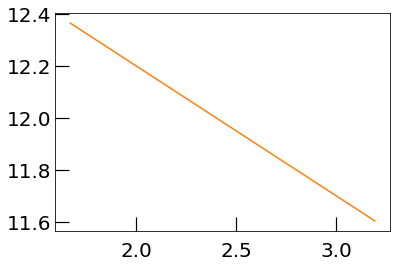

In [29]:
plt.errorbar(mean_nu, np.log10(y), yerr=yerr/(y*np.log(10)))
plt.plot(mean_nu, x0[0]*mean_nu + x0[1])

best_fit_params, flatchain = run_model_chains(Nwalkers, Ndim, Nsample, model_log_linear, mean_nu, np.log10(y), np.sum(yerr/(y*np.log(10)), axis=0), x0, \
                                 burn_in=burn_in, thin=thin, maxlag=maxlag, savefile=True, filename=filename, verbose=True)

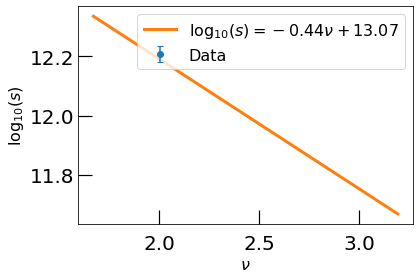

In [31]:
fontsize = 16
plt.errorbar(mean_nu, np.log10(y), yerr=yerr/(y*np.log(10)), marker="o", capsize=3, linestyle='None', label='Data')
plt.plot(mean_nu, -0.43856065*mean_nu + 13.0681573, linewidth=3, label=r'$\log_{10}(s) = -0.44\nu + 13.07$')
plt.xlabel(r'$\nu$', fontsize=fontsize)
plt.ylabel(r'$\log_{10}(s)$', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.savefig(plotdir+'scale_peakheight.pdf')

### Plotting data vs peak height

Change this plot in the following
* No measurements -- demonstrate the Chi-square p-value
* Different color using a color scheme

In [32]:
from mcmc_full_models import *
import matplotlib
from glob import glob

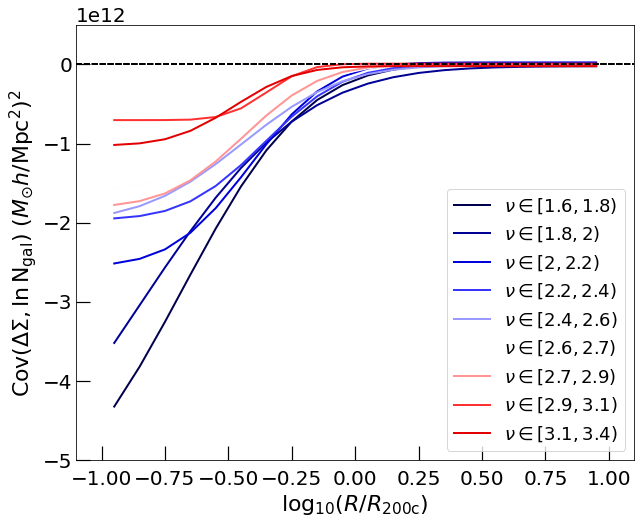

In [34]:
#fig, axs = plt.subplots(2, 5, figsize=(10,8), tight_layout=True, sharex=True, sharey=True)
plt.figure(figsize=(10,8))
fontsize=22
nBootstrap=10

split_samp_bins_edge = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
#split_samp_bins_edge = [90,100]
x_var_bin = [[] for i in range(len(split_samp_bins_edge)-1)]
bin_num = len(x_var_bin)
        
files = sorted(glob(chainsdir + 'R200c_binned/Dsep_R200c/' + 'chains_nu_*'))
Ndim = 4
model = model_erf

cmap = matplotlib.cm.get_cmap('seismic')
    
for k, file in enumerate(files):
        if k>= 9: break 
        bin_low = split_samp_bins_edge[k]
        bin_high = split_samp_bins_edge[k+1]
        
        rgba = cmap((k+0.02)/bin_num)

        x_var = matched_halo_df['nu']
        percentile_x_var = np.vectorize(lambda x: stats.percentileofscore(x_var, x))(x_var)
        mask = (percentile_x_var >= bin_low) & (percentile_x_var < bin_high)

        x_var_bin[k] = x_var[mask]
        cur_df = matched_halo_df[mask] ##This needs to change

        if len(cur_df) < 100: 
            #axs[i,j].set_visible(False)
            continue
        
        ##Compute Cov. and error total
        xline, output = calc_cov_KLLR(np.log10(np.array(cur_df['M200c'],dtype=float)) , np.array(np.vstack(cur_df['delta_sigma']), dtype=float), \
                                           np.log10(np.array(cur_df['Ngal_R200c'],dtype=float)), nBootstrap=nBootstrap)

        cov_ds_ngal_kllr = output['covariance']
        cov_mean_kllr = np.mean(cov_ds_ngal_kllr, axis=0)
        cov_err_kllr = np.std(cov_ds_ngal_kllr, axis=0)

        ##Data vector for chains
        x_data = r_cent_log_norm; y_data = cov_mean_kllr; y_err = cov_err_kllr

        try:
            f = h5py.File(file,'r')
        except:
            continue
        chain = np.array(f['chains'])
        
        best_fit_params, DIC_model, BIC_model, p_val = posterior_summary_stats(chain, model, Ndim, x_data, y_data, y_err, verbose=False)
        fit = model(best_fit_params[:,0], x_data)
        
        label_cur = r'$\nu \in [{:.2g}, {:.2g})$'.format(np.min(cur_df.nu), np.max(cur_df.nu))
        plt.plot(x_data, fit, label=label_cur, color=rgba, linewidth=2)
        
    
        ##Plotting configure
        plt.axhline(0,linestyle='dashed', color='black')
        
        
#plt.title(r'$\nu \in [{:.2g}, {:.2g})$'.format(np.min(cur_df.nu), np.max(cur_df.nu)), fontsize=fontsize)
plt.ylim([-5e12,0.5e12])   
plt.xlim([-1.1,1.1])
plt.legend(loc='best', fontsize=18)

plt.xlabel(r'$\log_{10}(R/R_{\rm 200c})$', fontsize=fontsize)
plt.ylabel(r'$\rm{Cov}(\Delta\Sigma, \lnN_{\rm gal})$ ($M_{\odot}h$/Mpc$^2$)$^2$', fontsize=fontsize, rotation='vertical')

plt.savefig(plotdir+'cov_nu_erf_full.pdf', bbox_inches='tight')
plt.show()